Logistic Regression classifier  

In [2]:
# Import packages

# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, svm, decomposition
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler

from sklearn.feature_selection import SelectKBest, mutual_info_classif

from hn.load_data import load_data
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegressionCV

In [3]:
# Preprocessing function of PCA

def data_preprocessing_PCA(X_train, X_validation):
    '''Data preprocessing PCA'''

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Feature selection/extraction
    pca = decomposition.PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca


In [4]:
# Preprocessing function of Univariate Analysis 

def data_preprocessing_Uni(X_train, y_train, X_test, y_test):
    '''Data preprocessing Univariate'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_test_scaled = scaler.transform(X_test)
    df_X_test_scaled = pd.DataFrame(X_test_scaled)
    
    # 2. Feature selection/extraction
    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(10,'Score'))  #print 10 best features
    best_features = featureScores.nlargest(10,'Score')['Specs']

    df_X_train_features = df_X_train_scaled[best_features]
    df_X_test_features = df_X_test_scaled[best_features]

    return df_X_train_features, df_X_test_features 


In [5]:
# learning curve function

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

In [9]:
# Loading of data 
from hn.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

# Split data in a train and test set

split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)


The number of samples: 113
The number of features: 159


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of 160 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.5s finished
l1
0.08858667904100823
liblinear
0.8736979166666667
0.6956521739130435
####################################################################################################
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.3s finished
l1
0.08858667904100823
liblinear
0.7938368055555556
0.8260869565217391
####################################################################################################
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1

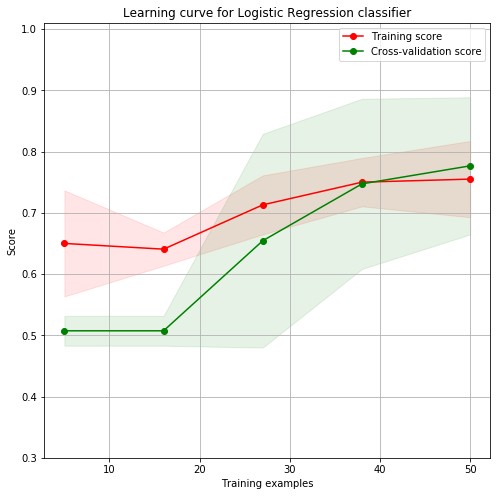

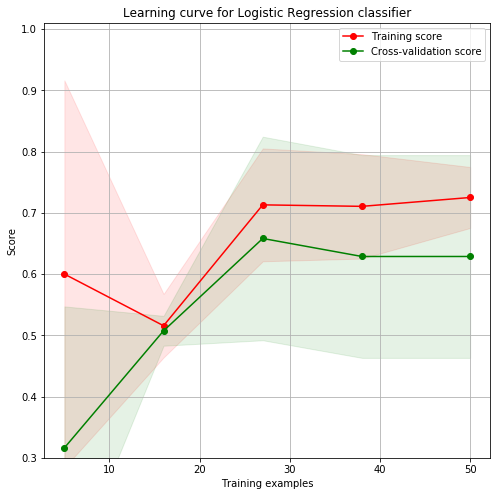

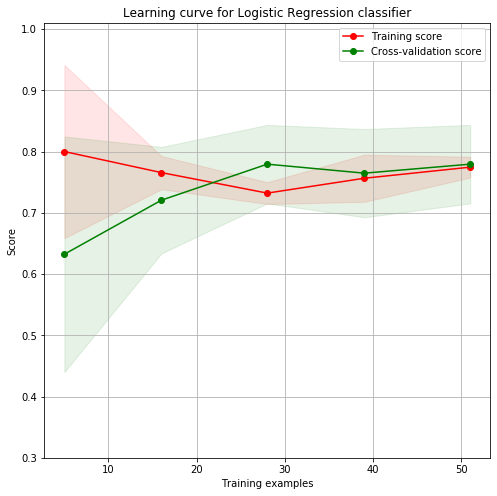

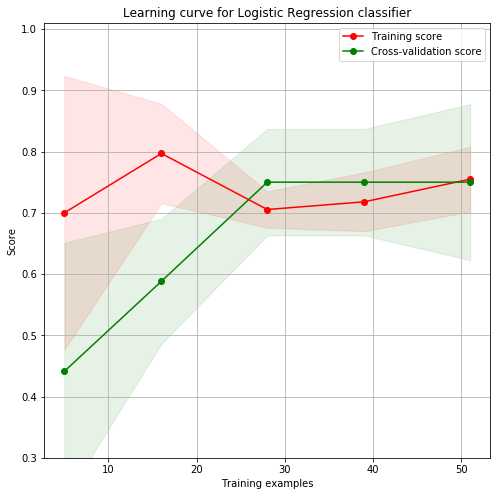

In [27]:

# Loop over the folds
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    #print(f'Validation size in current fold = {len(X_validation)}')
    X_train_pca, X_validation_pca = data_preprocessing_Uni(X_train, y_train, X_validation, y_validation)

    # Hyperparameter tuning
    grid_param = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}
    grid_search=GridSearchCV(LogisticRegression(),param_grid=grid_param, cv=cv_4fold,n_jobs=-1,verbose=2, scoring='roc_auc') 
    grid_search.fit(X_train_pca, y_train)

    best_hyperparameters = grid_search.best_params_

    penalty=best_hyperparameters.get('penalty')
    C=best_hyperparameters.get('C')
    solver=best_hyperparameters.get('solver')
    print(penalty)
    print(C)
    print(solver)
    best_result = grid_search.best_score_  
    print(best_result)

    # Classification with tuned hyperparameters
    clf_lr = LogisticRegression(penalty=penalty, C=C, solver=solver)
    clf_lr.fit(X_train_pca, y_train)


    
    # Calculate accuracy
    clf_lr_predictions=clf_lr.predict(X_validation_pca)

    accuracy=metrics.accuracy_score(y_validation, clf_lr_predictions)
    print(accuracy)
    print('#'*100)

    # Learning curve
    # Now use the classifiers on all datasets
    title = 'Learning curve for Logistic Regression classifier'
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plot_learning_curve(clf_lr, title, X_train_pca, y_train, ax, ylim=(0.3, 1.01), cv=cv_4fold)

In [28]:

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)

grid_param = {'penalty' : ['l1', 'l2'],
'C' : np.logspace(-4, 4, 20),
'solver' : ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(),param_grid=grid_param, cv=cv_4fold,n_jobs=-1,verbose=2, scoring='roc_auc') 

train_all = []
test_all = []
for _ in range(4):
    for train_index, test_index in cv_4fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]


        # Data preprocessing
        df_X_train_features, df_X_test_features = data_preprocessing_Uni(X_train, y_train, X_test, y_test)

        grid_search.fit(df_X_train_features, y_train) 
        clf_lr = grid_search.best_estimator_
        

        # Tests 
        train_proba = clf_lr.predict_proba(df_X_train_features)[:, 1]
        test_proba = clf_lr.predict_proba(df_X_test_features)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)


        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(test_scores_mean)
print(test_scores_std)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.5s finished
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.4s finished
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of 160 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.4s finished
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.4s finished
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]